## Neural Network Model Analysis on House Prices

### Load the Preprocessed Data

In [34]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed training and testing data
X_train = pd.read_csv('C:\\Users\\Smq\\Desktop\\X_train.csv')
y_train = pd.read_csv('C:\\Users\\Smq\\Desktop\\y_train.csv').squeeze()
X_test = pd.read_csv('C:\\Users\\Smq\\Desktop\\X_test.csv')
y_test = pd.read_csv('C:\\Users\\Smq\\Desktop\\y_test.csv').squeeze()
        

### Initialize and Train the Neural Network Model

In [35]:

# Initialize the Neural Network Model with more iterations and a dynamic learning rate
nn_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                        alpha=0.0001, batch_size='auto', learning_rate='adaptive', 
                        learning_rate_init=0.001, max_iter=100000, random_state=42, validation_fraction=0.1)

# Train the model with the training data
nn_model.fit(X_train, y_train)
        

MLPRegressor(learning_rate='adaptive', max_iter=100000, random_state=42)

### Predict and Evaluate the Model

In [36]:

# Predict the Test set results
y_pred_nn = nn_model.predict(X_test)

# Evaluate the Neural Network Model Performance
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
medae_nn = median_absolute_error(y_test, y_pred_nn)
# Output model performance
print('Neural Network Model Performance:')
print('Mean Squared Error:', mse_nn)
print('R-squared Score:', r2_nn)
print('Mean Absolute Error:', mae_nn)
print('Median Absolute Error:', medae_nn) 
        

Neural Network Model Performance:
Mean Squared Error: 2260449011.0670147
R-squared Score: 0.6605995146131043
Mean Absolute Error: 30838.132860853508
Median Absolute Error: 19222.05798895289


### Model Settings

In [37]:
print('Neural Network Model Settings:')
print(nn_model.get_params())

Neural Network Model Settings:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


### Visualization of Predictions

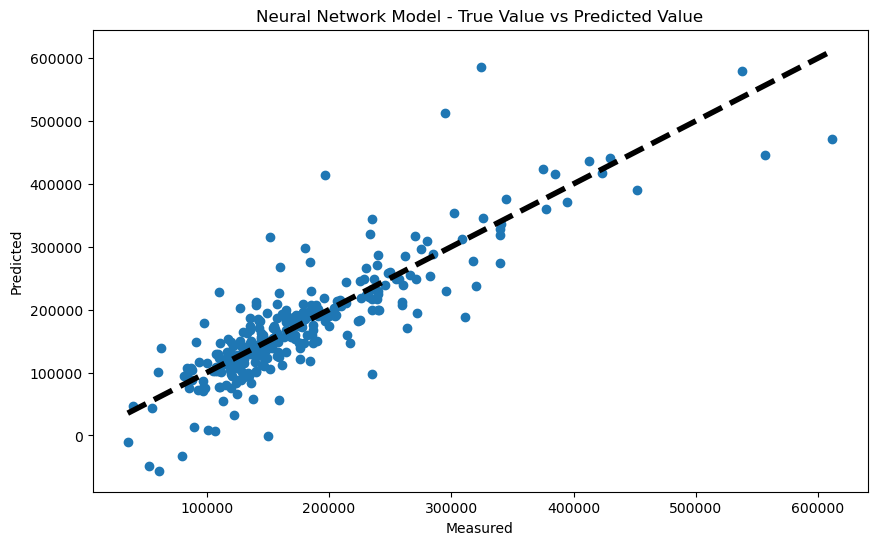

In [38]:

# Plotting the true vs predicted values for visual analysis
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_nn)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Model - True Value vs Predicted Value')
plt.show()
        